In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-driv/e-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir('/content/drive')

In [0]:
!pip install pydub
!pip install soundfile
!pip install tqdm
!pip install msgpack
!pip install msgpack_numpy
!pip install tabulate
!apt-get install libsndfile1
!apt-get install libsndfile-dev
!pip install librosa==0.5.0
!pip install scikits.audiolab==0.11.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libsndfile1-dev' instead of 'libsndfile-dev'
libsndfile1-dev is already the newest version (1.0.28-4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [0]:
import os
os.chdir("/content/drive/App/Speaker_Recognition")
!ls
import tensorflow as tf
import numpy as np
import librosa

asset  lstm_method.py  Untitled0.ipynb


In [0]:
!ls asset

LSTM_train


In [0]:
!python lstm_method.py

python3: can't open file 'lstm_method.py': [Errno 2] No such file or directory


In [0]:
import pandas as pd
df = pd.read_csv('/content/drive/App/common_voice/cv-valid-test.csv')

In [0]:
accent = df[['filename','accent']]
accent.dropna(inplace=True)
t=1000
accent = accent[:t]
accent.accent.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


us             83
england        53
canada         20
indian         16
australia      10
scotland        7
newzealand      3
ireland         2
african         2
philippines     2
hongkong        1
wales           1
Name: accent, dtype: int64

In [0]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.3.4-2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [0]:
from pydub import AudioSegment
audio_list = []
for loc in accent.filename[:t]:
  wav, _ = librosa.load('/content/drive/App/common_voice/'+loc, mono=True, sr=16000)
  #wav = AudioSegment.from_mp3('/content/drive/App/common_voice/'+loc)
  mfcc = np.transpose(np.expand_dims(librosa.feature.mfcc(wav, 16000), axis=0), [0, 2, 1])
  mfcc = mfcc.reshape(-1,20)
  new_len = (20-mfcc.shape[0]%20)%20
  mfcc = np.vstack((mfcc,np.zeros((new_len, 20))))
  audio_list.append(mfcc)

In [0]:
accent['mfcc'] = audio_list
accent.head()

,filename,accent,mfcc
3,cv-valid-test/sample-000003.mp3,us,"[[-756.3875899491114, -7.258480577214905e-14, ..."
5,cv-valid-test/sample-000005.mp3,us,"[[-550.2718285982077, 21.233028321917338, 11.4..."
8,cv-valid-test/sample-000008.mp3,england,"[[-565.4352033250681, -2.0028037656225973e-14,..."
9,cv-valid-test/sample-000009.mp3,us,"[[-607.955007445543, 53.47701837856058, 37.603..."
14,cv-valid-test/sample-000014.mp3,scotland,"[[-630.6569435166367, -2.852734546217624e-14, ..."


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()                                                       
label_integer_encoded = label_encoder.fit_transform(accent.accent)                         
labels = label_integer_encoded
label_onehot_encoder = OneHotEncoder(sparse=False)
label_integer_encoded = label_integer_encoded.reshape(len(label_integer_encoded), 1)
label_hot = label_onehot_encoder.fit_transform(label_integer_encoded)

#accent['accent'] = label_hot
#accent.head()

In [0]:
voice_data = audio_list

np.random.seed(1)
batch_size = 1
n_steps = 20
epochs = 30
input_dim = 20
hidden_dim = 100
output_dim = 10

with tf.variable_scope("SpeakerRecognition") :
    #  Sequences we will provide at runtime
    seq_input = tf.placeholder(tf.float32, [None, input_dim])
    Y_batch = tf.placeholder(tf.float32, [output_dim,])
    pseudo_batch_size = tf.placeholder(tf.int32,[])
    #  What timestep we want to stop at
    #early_stop = tf.placeholder(tf.int32)
    # seq_len = tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_sum(x,axis=2), 0.), tf.int32),axis=1)
    initializer = tf.contrib.layers.xavier_initializer()

    seq_input_1 = tf.transpose(tf.reshape(seq_input, (-1,n_steps,input_dim)), perm = [1,0,2])

    #  Inputs for rnn needs to be a list, each item being a timestep.
    #  we need to split our input into each timestep, and reshape it because
    #  split keeps dims by default
    inputs = [tf.reshape(i, (-1, input_dim)) for i in tf.split(seq_input_1, n_steps, axis = 0)]    
    Y_batch_1 = tf.reshape(tf.tile(Y_batch, tf.reshape(pseudo_batch_size, (1,))), (-1,output_dim))

    #tf.get_variable_scope().reuse_variables()
    
    cell1 = tf.contrib.rnn.LSTMCell(hidden_dim, input_dim, initializer=initializer)
    cell1 = tf.contrib.rnn.DropoutWrapper(cell1, output_keep_prob=0.25)
    initial_state1 = cell1.zero_state(pseudo_batch_size, tf.float32)
    outputs1, states1 = tf.contrib.rnn.static_rnn(cell1, inputs, initial_state=initial_state1, scope="RNN1")#sequence_length=early_stop


    cell2 = tf.contrib.rnn.LSTMCell(hidden_dim, hidden_dim, initializer=initializer)
    cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=0.25)
    initial_state2 = cell2.zero_state(pseudo_batch_size, tf.float32)
    outputs2, states2 = tf.contrib.rnn.static_rnn(cell2, outputs1, initial_state=initial_state2, scope="RNN2")#sequence_length=early_stop

    cell3 = tf.contrib.rnn.LSTMCell(hidden_dim, hidden_dim, initializer=initializer)
    cell3 = tf.contrib.rnn.DropoutWrapper(cell3, output_keep_prob=0.25)
    initial_state3 = cell3.zero_state(pseudo_batch_size, tf.float32)
    outputs3, states3 = tf.contrib.rnn.static_rnn(cell3, outputs2, initial_state=initial_state3,scope="RNN3")#sequence_length=early_stop

    dense_out = tf.layers.dense(outputs3[-1], output_dim)
    soft_prob = tf.nn.softmax(dense_out)
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_batch_1, logits=dense_out))
    #train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Create initialize op, this needs to be run by the session!
    iop = tf.initialize_all_variables()
    #tf.get_variable_scope().reuse_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [0]:
saver = tf.train.Saver()
# Create session with device logging
session = tf.Session()

# Actually initialize, if you don't do this you get errors about uninitialized
session.run(iop)

saver.restore(session, "asset/LSTM_train/model.ckpt")
print("Model restored !!")

embeddings = []

num_batches_test = len(voice_data)
for batch in range(num_batches_test):
  batch_input = voice_data[batch]
  y_pred = session.run(soft_prob, feed_dict={seq_input: batch_input.astype('float32'), pseudo_batch_size: batch_input.shape[0] // n_steps})
  avg_y_pred = np.mean(y_pred, axis = 0)
  embeddings.append(avg_y_pred)

INFO:tensorflow:Restoring parameters from asset/LSTM_train/model.ckpt
Model restored !!


In [0]:
embeddings = np.asarray(embeddings)
np.savetxt("asset/TSNE/labels.csv",labels,delimiter=",")

In [1]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(embeddings)
X_embedded.shape

NameError: ignored

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
No handles with labels found to put in legend.


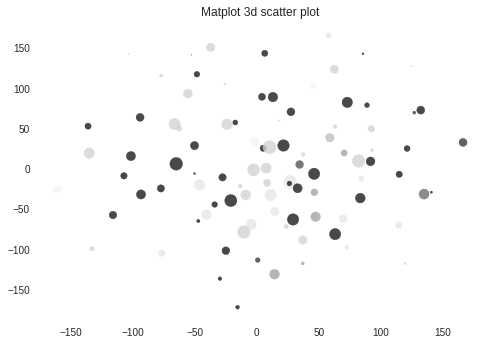

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
 
x = X_embedded[:,0]
y = X_embedded[:,1]
z = X_embedded[:,2]

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
#ax = fig.gca(projection='3d')
ax.scatter(x, y, z, alpha=0.8, c=labels)
 
plt.title('Matplot 3d scatter plot')
plt.legend(loc=2)
plt.show()